In [10]:
# read cities.txt (id, lat, lon) and plot every city on a map
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import networkx as nx
import pandas as pd
import os, time, sys, random, math

In [ ]:
# read us-cities-top-1k.csv
df = pd.read_csv('us-cities-top-1k.csv') # cols = ['City', 'State', 'Population', 'lat', 'lon']
# sort by population
df = df.sort_values(by='Population', ascending=False)

with open('cities.txt', 'w') as f:
    for idx, (i, row) in enumerate(df.iterrows()):
        f.write(f'{idx+1} {row["lat"]:.2f} {row["lon"]:.2f} {row["Population"]} {row["City"].replace(" ", "_")}\n')
        if idx > 10000:
            break

In [11]:
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        id, lat, lon, pop = line.split()
        cities.append((id, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [lat for id, lat, lon, pop in cities]
    lons = [lon for id, lat, lon, pop in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = [(id, lat, lon, pop) for id, lat, lon, pop in cities if abs(lat - lat_mean) < 3 * lat_std and abs(lon - lon_mean) < 3 * lon_std]
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    plt.figure(figsize=(12, 8))  # Reduced the figure size for practicality
    lats = [lat for id, lat, lon, pop in cities]
    lons = [lon for id, lat, lon, pop in cities]
    pops = [pop for id, lat, lon, pop in cities]
    # Normalize population values for markersize if needed
    min_pop = min(pops)
    max_pop = max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("City Plot")
    plt.show()

Read 1000 cities from cities.txt


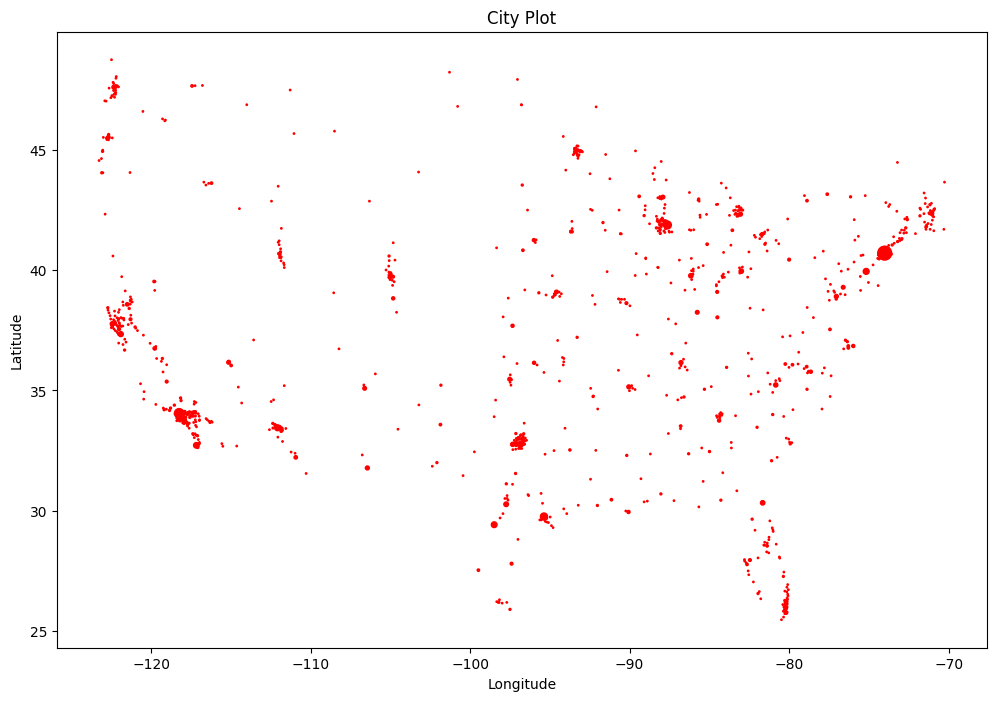

In [12]:
cities = read_cities("cities.txt")
cities = remove_outliers(cities)
plot_cities(cities)

In [27]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c # distance in km

# Determine how redundant each city is based on other cities
def redundancy_1(cities):
    r = [0] * len(cities)
    for i in range(len(cities)):
        for j in range(i + 1, len(cities)):
            ci = cities[i]
            cj = cities[j]
            lat1, lon1 = ci[1], ci[2]
            lat2, lon2 = cj[1], cj[2]
            d = distance(lat1, lon1, lat2, lon2)
            p1, p2 = ci[3], cj[3]
            if p1 > p2:
                r[j] += p2 / p1 * d
            elif p2 > p1:
                r[i] += p1 / p2 * d
    return r
    

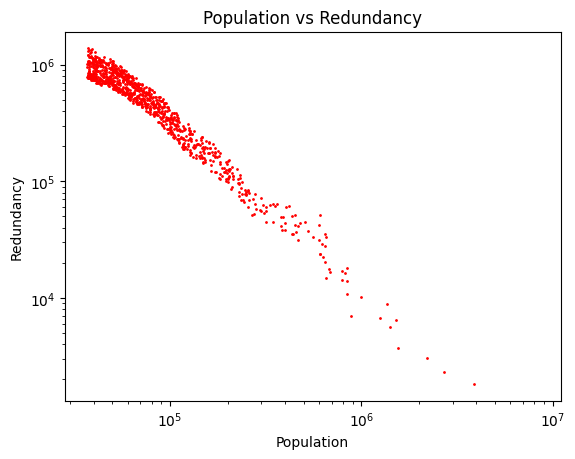

In [28]:
# keep the 100 most redundant cities
scores = redundancy_1(cities)
pops = [pop for id, lat, lon, pop in cities]
# plot graph between redundancy and population
plt.scatter(pops, scores, c="red", s=1)
plt.xlabel("Population")
plt.ylabel("Redundancy")
plt.yscale("log")
plt.xscale("log")
plt.title("Population vs Redundancy")
plt.show()

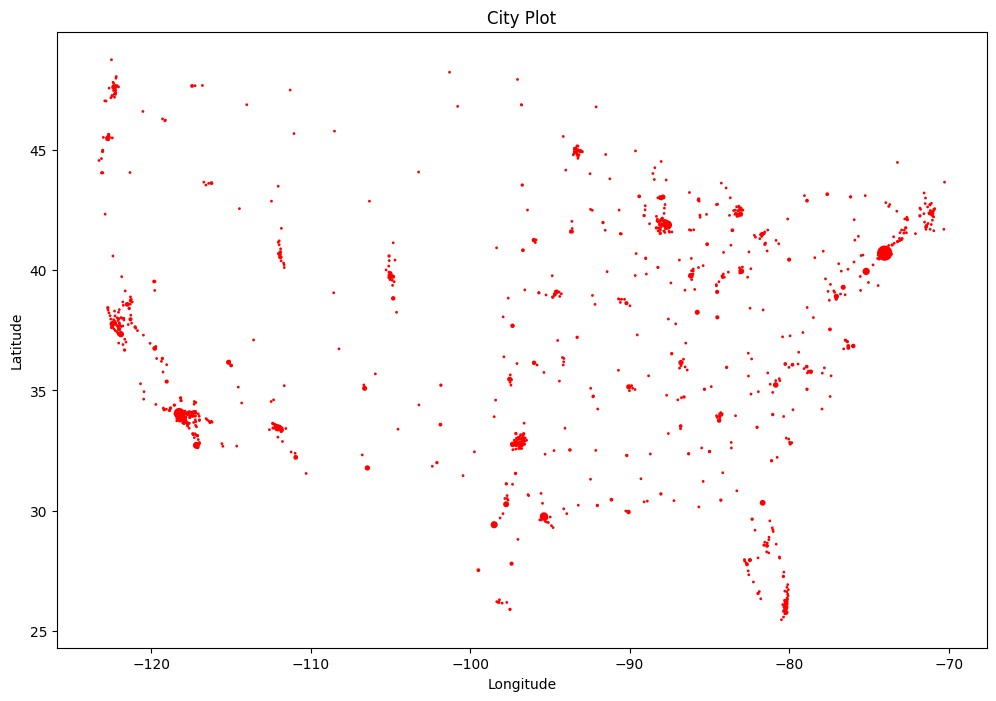

In [33]:
# keep the 100 least redundant cities
cities1 = [cities[i] for i in np.argsort(scores)[:1000]]
plot_cities(cities1)